In [1]:
from __future__ import print_function
from IPython import display

In [2]:
checkpoint_name = 'mobilenet_v2_1.0_96' #@param
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'

In [3]:
print('Downloading from ', url)
!wget {url}
print('Unpacking')
!tar -xvf {checkpoint_name}.tgz
checkpoint = checkpoint_name + '.ckpt'

display.clear_output()
print('Successfully downloaded checkpoint from ', url,'. It is available as', checkpoint)

Successfully downloaded checkpoint from  https://storage.googleapis.com/mobilenet_v2/checkpoints/mobilenet_v2_1.0_96.tgz . It is available as mobilenet_v2_1.0_96.ckpt


In [4]:
# setup path
import sys
sys.path.append('./models/research/slim')

In [5]:
import tensorflow as tf
from nets.mobilenet import mobilenet_v2

tf.reset_default_graph()

# For simplicity we just decode jpeg inside tensorflow.
# But one can provide any input obviously.
file_input = tf.placeholder(tf.string, ())

image = tf.image.decode_jpeg(tf.read_file(file_input))

images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (96, 96))

# Note: arg_scope is optional for inference.
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
    logits, endpoints = mobilenet_v2.mobilenet(images)

# Restore using exponential moving average since it produces (1.5-2%) higher 
# accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)

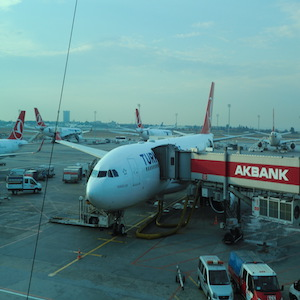

INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_96.ckpt
Top 1 prediction:  405 airliner 0.9560601


In [6]:
from IPython import display
import pylab
from datasets import imagenet
import PIL
display.display(display.Image('./test.jpg'))

with tf.Session() as sess:
    saver.restore(sess,  checkpoint)
    x = endpoints['Predictions'].eval(feed_dict={file_input: './test.jpg'})

label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 prediction: ", x.argmax(),label_map[x.argmax()], x.max())